# atai

> Atomic AI – An attempt at a minimalist, flexible deep learning framework for diverse models.

Atomic AI is a flexible, minimalist deep neural network training framework based on Jeremy Howard's [miniai](https://github.com/fastai/course22p2/tree/master) from the [fast.ai 2022](https://course.fast.ai/Lessons/part2.html) course.

## Install

```sh
pip install atai
```

## How to use

In [ ]:
from atai.core import *

The following example demonstrates how the Atomic AI training framework can be used to train a custom model that predicts protein solubility.

### Imports

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import init
from torch import optim

from torcheval.metrics import BinaryAccuracy, BinaryAUROC
from torcheval.metrics.functional import binary_auroc, binary_accuracy
from torchmetrics.classification import BinaryMatthewsCorrCoef
from torchmetrics.functional.classification import binary_matthews_corrcoef

import fastcore.all as fc
from functools import partial

In [ ]:
#| hide
%matplotlib inline
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)

### Load Protein Solubility

This example uses the dataset from the [DeepSol](https://doi.org/10.1093/bioinformatics/bty166) paper by Khurana *et al.* which was obtained at [https://zenodo.org/records/1162886](https://zenodo.org/records/1162886). It consists of amino acid sequences of peptides along with solubility labels that are `1` if the peptide is soluble and `0` if the peptide is insoluble.

In [ ]:
train_sqs = open('sol_data/train_src', 'r').read().splitlines()
train_tgs = list(map(int, open('sol_data/train_tgt', 'r').read().splitlines()))

valid_sqs = open('sol_data/val_src', 'r').read().splitlines()
valid_tgs = list(map(int, open('sol_data/val_tgt', 'r').read().splitlines()))

train_sqs[:2], train_tgs[:2]

(['GMILKTNLFGHTYQFKSITDVLAKANEEKSGDRLAGVAAESAEERVAAKVVLSKMTLGDLRNNPVVPYETDEVTRIIQDQVNDRIHDSIKNWTVEELREWILDHKTTDADIKRVARGLTSEIIAAVTKLMSNLDLIYGAKKIRVIAHANTTIGLPGTFSARLQPNHPTDDPDGILASLMEGLTYGIGDAVIGLNPVDDSTDSVVRLLNKFEEFRSKWDVPTQTCVLAHVKTQMEAMRRGAPTGLVFQSIAGSEKGNTAFGFDGATIEEARQLALQSGAATGPNVMYFETGQGSELSSDAHFGVDQVTMEARCYGFAKKFDPFLVNTVVGFIGPEYLYDSKQVIRAGLEDHFMGKLTGISMGCDVCYTNHMKADQNDVENLSVLLTAAGCNFIMGIPHGDDVMLNYQTTGYHETATLRELFGLKPIKEFDQWMEKMGFSENGKLTSRAGDASIFLK',
  'MAHHHHHHMSFFRMKRRLNFVVKRGIEELWENSFLDNNVDMKKIEYSKTGDAWPCVLLRKKSFEDLHKLYYICLKEKNKLLGEQYFHLQNSTKMLQHGRLKKVKLTMKRILTVLSRRAIHDQCLRAKDMLKKQEEREFYEIQKFKLNEQLLCLKHKMNILKKYNSFSLEQISLTFSIKKIENKIQQIDIILNPLRKETMYLLIPHFKYQRKYSDLPGFISWKKQNIIALRNNMSKLHRLY'],
 [1, 0])

In [ ]:
len(train_sqs), len(train_tgs), len(valid_sqs), len(valid_tgs)

(62478, 62478, 6942, 6942)

### Data Preparation

Create a sorted list of amino acid sequences `aas` including an empty string for padding and determine the size of the vocabulary.

In [ ]:
aas = sorted(list(set("".join(train_sqs))) + [""])
vocab_size = len(aas)
aas, vocab_size

(['',
  'A',
  'C',
  'D',
  'E',
  'F',
  'G',
  'H',
  'I',
  'K',
  'L',
  'M',
  'N',
  'P',
  'Q',
  'R',
  'S',
  'T',
  'V',
  'W',
  'Y'],
 21)

Create dictionaries that translate between string and integer representations of amino acids and define the corresponding `encode` and `decode` functions.

In [ ]:
str2int = {aa:i for i, aa in enumerate(aas)}
int2str = {i:aa for i, aa in enumerate(aas)}
encode = lambda s: [str2int[aa] for aa in s]
decode = lambda l: ''.join([int2str[i] for i in l])

print(encode("AYWCCCGGGHH"))
print(decode(encode("AYWCCCGGGHH")))

[1, 20, 19, 2, 2, 2, 6, 6, 6, 7, 7]
AYWCCCGGGHH


Figure out what the range of lengths of amino acid sequences in the dataset is.

In [ ]:
train_lens = list(map(len, train_sqs))
min(train_lens), max(train_lens)

(19, 1691)

Create a function that drops all sequences above a chosen threshold and also returns a list of indices of the sequences that meet the threshold that can be used to obtain the correct labels.

In [ ]:
def drop_long_sqs(sqs, threshold=1200):
    new_sqs = []
    idx = []
    for i, sq in enumerate(sqs):
        if len(sq) <= threshold:
            new_sqs.append(sq)
            idx.append(i)
    return new_sqs, idx

Drop all sequences above your chosen threshold.

In [ ]:
trnsqs, trnidx = drop_long_sqs(train_sqs, threshold=200)
vldsqs, vldidx = drop_long_sqs(valid_sqs, threshold=200)

In [ ]:
len(trnidx), len(vldidx)

(18066, 1971)

In [ ]:
max(map(len, trnsqs))

200

Create a function for zero padding all sequences.

In [ ]:
def zero_pad(sq, length=1200):
    new_sq = sq.copy()
    if len(new_sq) < length:
        new_sq.extend([0] * (length-len(new_sq)))
    return new_sq

Now encode and zero pad all sequences and make sure that it worked out correctly.

In [ ]:
trn = list(map(encode, trnsqs))
vld = list(map(encode, vldsqs))
print(f"Length of the first two sequences before zero padding: {len(trn[0])}, {len(trn[1])}")
trn = list(map(partial(zero_pad, length=200), trn))
vld = list(map(partial(zero_pad, length=200), vld))
print(f"Length of the first two sequences after zero padding:  {len(trn[0])}, {len(trn[1])}");

Length of the first two sequences before zero padding: 116, 135
Length of the first two sequences after zero padding:  200, 200


Convert the data to `torch.tensor`s unsing `dtype=torch.int64` and check for correctness.

In [ ]:
trntns = torch.tensor(trn, dtype=torch.int64)
vldtns = torch.tensor(vld, dtype=torch.int64)
trntns.shape, trntns[0]

(torch.Size([18066, 200]),
 tensor([11,  9,  1, 10,  2, 10, 10, 10, 10, 13, 18, 10,  6, 10, 10, 18, 16, 16,  9, 17, 10,  2, 16, 11,  4,  4,  1,  8, 12,  4, 15,  8, 14,
          4, 18,  1,  6, 16, 10,  8,  5, 15,  1,  8, 16, 16,  8,  6, 10,  4,  2, 14, 16, 18, 17, 16, 15,  6,  3, 10,  1, 17,  2, 13, 15,  6,
          5,  1, 18, 17,  6,  2, 17,  2,  6, 16,  1,  2,  6, 16, 19,  3, 18, 15,  1,  4, 17, 17,  2,  7,  2, 14,  2,  1,  6, 11,  3, 19, 17,
          6,  1, 15,  2,  2, 15, 18, 14, 13, 10,  4,  7,  7,  7,  7,  7,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0]))

In [ ]:
trntns.shape, vldtns.shape

(torch.Size([18066, 200]), torch.Size([1971, 200]))

Obtain the correct labels using the lists of indices obtained from the `drop_long_sqs` function and convert the lists of labels to tensors in `torch.float32` format.

In [ ]:
trnlbs = torch.tensor(train_tgs, dtype=torch.float32)[trnidx]
vldlbs = torch.tensor(valid_tgs, dtype=torch.float32)[vldidx]
trnlbs.shape, vldlbs.shape

(torch.Size([18066]), torch.Size([1971]))

Calculate the ratios of soluble peptides in the train and valid data.

In [ ]:
trnlbs.sum().item()/trnlbs.shape[0], vldlbs.sum().item()/vldlbs.shape[0]

(0.4722129967895494, 0.4657534246575342)

These ratios tell us that there are slightly less than half soluble proteins in the training an validation data, and slightly more than half in the test set.

### Dataset and DataLoaders

Turn train and valid data into datasets using the `Dataset` class.

In [ ]:
trnds = Dataset(trntns, trnlbs)
vldds = Dataset(vldtns, vldlbs)
trnds[0]

(tensor([11,  9,  1, 10,  2, 10, 10, 10, 10, 13, 18, 10,  6, 10, 10, 18, 16, 16,  9, 17, 10,  2, 16, 11,  4,  4,  1,  8, 12,  4, 15,  8, 14,
          4, 18,  1,  6, 16, 10,  8,  5, 15,  1,  8, 16, 16,  8,  6, 10,  4,  2, 14, 16, 18, 17, 16, 15,  6,  3, 10,  1, 17,  2, 13, 15,  6,
          5,  1, 18, 17,  6,  2, 17,  2,  6, 16,  1,  2,  6, 16, 19,  3, 18, 15,  1,  4, 17, 17,  2,  7,  2, 14,  2,  1,  6, 11,  3, 19, 17,
          6,  1, 15,  2,  2, 15, 18, 14, 13, 10,  4,  7,  7,  7,  7,  7,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0]),
 tensor(0.))

Use the `get_dls` function to obtain the dataloaders from the train and valid datasets.

In [ ]:
dls = get_dls(trnds, vldds, bs=32)
next(iter(dls.train))[0][:2], next(iter(dls.train))[1][:2]

(tensor([[10, 15, 16, 18,  5, 18, 16,  6,  5, 13, 15,  6, 18,  3, 16,  1, 14, 10, 16,  4, 20,  5, 10,  1,  5,  6, 13, 18,  1, 16, 18, 18, 11,
           3,  9,  3,  9,  6, 18,  5,  1,  8, 18,  4, 11,  6,  3, 18,  6,  1, 15,  4,  1, 18, 10, 16, 14, 16, 14,  7, 16, 10,  6,  6,  7, 15,
          10, 15, 18, 15, 13, 15,  4, 14,  9,  4,  5, 14, 16, 13,  1, 16,  9, 16, 13,  9,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0],
         [11, 12, 13, 16,  1, 13, 16, 20, 13, 11,  1, 16, 10, 20, 18,  6,  3, 10,  7, 13,  3, 18, 17,  4,  1, 11, 10, 20,  4,  9,

### Design Your Model

Let's create a tiny model (~10k parameters) that uses a sequence of 1-dimensional convolutional layers with skip connections, kaiming he initialization, leaky relus, batchnorm, and dropout.

First, obtain a single batch from `dls` to help design the model.

In [ ]:
idx = next(iter(dls.train))[0] ## a single batch
idx, idx.shape

(tensor([[11,  9,  9,  ...,  0,  0,  0],
         [11,  3, 20,  ...,  0,  0,  0],
         [ 1,  5,  4,  ...,  0,  0,  0],
         ...,
         [ 1, 18, 18,  ...,  0,  0,  0],
         [10,  6,  5,  ...,  0,  0,  0],
         [ 2,  8,  1,  ...,  0,  0,  0]]),
 torch.Size([32, 200]))

#### Custom Modules

In [ ]:
def conv1d(ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=None):
    if bias is None: bias = not isinstance(norm, (nn.BatchNorm1d,nn.BatchNorm2d,nn.BatchNorm3d))
    layers = [nn.Conv1d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return nn.Sequential(*layers)

def _conv1d_block(ni, nf, stride, act=nn.ReLU, norm=None, ks=3):
    return nn.Sequential(conv1d(ni, nf, stride=1, act=act, norm=norm, ks=ks),
                         conv1d(nf, nf, stride=stride, act=None, norm=norm, ks=ks))

class ResBlock1d(nn.Module):
    def __init__(self, ni, nf, stride=1, ks=3, act=nn.ReLU, norm=None):
        super().__init__()
        self.convs = _conv1d_block(ni, nf, stride=stride, ks=ks, act=act, norm=norm)
        self.idconv = fc.noop if ni==nf else conv1d(ni, nf, stride=1, ks=1, act=None)
        self.pool = fc.noop if stride==1 else nn.AvgPool1d(stride, ceil_mode=True)
        self.act = act()

    def forward(self, x): return self.act(self.convs(x) + self.pool(self.idconv(x)))

The following module switches the rank order from BLC to BCL.

In [ ]:
class Reshape(nn.Module):
    def forward(self, x): 
        B, L, C = x.shape
        return x.view(B, C, L)

#### Model Architecture

In [ ]:
lr = 1e-2
epochs = 30
n_embd = 16
dls = get_dls(trnds, vldds, bs=32)
act_genrelu = partial(GeneralRelu, leak=0.1, sub=0.4)

model = nn.Sequential(nn.Embedding(vocab_size, n_embd, padding_idx=0), Reshape(),
                      ResBlock1d(n_embd, 2, ks=15, stride=2, norm=nn.BatchNorm1d, act=act_genrelu), nn.Dropout(0.1),
                      ResBlock1d(2, 4, ks=13, stride=2, norm=nn.BatchNorm1d, act=act_genrelu), nn.Dropout(0.1),
                      ResBlock1d(4, 4, ks=11, stride=2, norm=nn.BatchNorm1d, act=act_genrelu), nn.Dropout(0.1),
                      ResBlock1d(4, 4, ks=9, stride=2, norm=nn.BatchNorm1d, act=act_genrelu), nn.Dropout(0.1),
                      ResBlock1d(4, 8, ks=7, stride=2, norm=nn.BatchNorm1d, act=act_genrelu), nn.Dropout(0.1),
                      ResBlock1d(8, 8, ks=5, stride=2, norm=nn.BatchNorm1d, act=act_genrelu), nn.Dropout(0.1),
                      ResBlock1d(8, 16, ks=3, stride=2, norm=nn.BatchNorm1d, act=act_genrelu), nn.Dropout(0.1),
                      ResBlock1d(16, 32, ks=3, stride=2, norm=nn.BatchNorm1d, act=act_genrelu), nn.Dropout(0.1),
                      nn.Flatten(1, -1),
                      nn.Linear(32, 1),
                      nn.Flatten(0, -1),
                      nn.Sigmoid())
model(idx).shape

torch.Size([32])

Parameters total: 10175


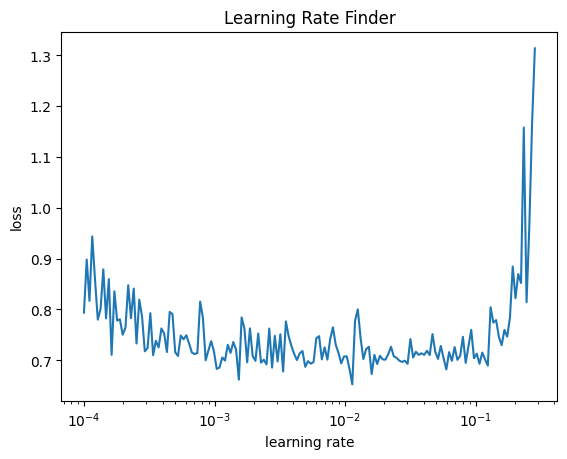

In [ ]:
iw = partial(init_weights, leaky=0.1)
model = model.apply(iw)
metrics = MetricsCB(BinaryAccuracy(), BinaryMatthewsCorrCoef(), BinaryAUROC())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), ProgressCB(plot=False), metrics, astats]
learn = TrainLearner(model, dls, F.binary_cross_entropy, lr=lr, cbs=cbs, opt_func=torch.optim.AdamW)
print(f"Parameters total: {sum(p.nelement() for p in model.parameters())}")
learn.lr_find(start_lr=1e-4, gamma=1.05, av_over=3, max_mult=5)

This is a pretty noisy training set, so the learning rate finder does not work very well. Yet it is possible to get a somewhat informative result using the `av_over` keyword argument that tells `lr_find` to average over the specified number of batches for each learning rate tested. It also helps to dial the `gamma` value down from its default value of `1.3`.

### Training

In [ ]:
learn.fit(epochs)

BinaryAccuracy,BinaryMatthewsCorrCoef,BinaryAUROC,loss,epoch,train
0.507,0.001,0.504,0.718,0,train
0.534,-0.021,0.514,0.691,0,eval
0.515,0.008,0.506,0.697,1,train
0.539,0.040,0.530,0.691,1,eval
0.519,0.015,0.509,0.695,2,train
0.534,0.003,0.498,0.691,2,eval
0.519,0.017,0.517,0.694,3,train
0.525,0.036,0.527,0.692,3,eval
0.582,0.155,0.592,0.675,4,train
0.638,0.283,0.649,0.633,4,eval


### Inspect Activations

In [ ]:
dls = get_dls(trnds, vldds, bs=256)

model = nn.Sequential(nn.Embedding(vocab_size, n_embd, padding_idx=0), Reshape(),
                      ResBlock1d(n_embd, 2, ks=15, stride=2, norm=nn.BatchNorm1d, act=act_genrelu), nn.Dropout(0.1),
                      ResBlock1d(2, 4, ks=13, stride=2, norm=nn.BatchNorm1d, act=act_genrelu), nn.Dropout(0.1),
                      ResBlock1d(4, 4, ks=11, stride=2, norm=nn.BatchNorm1d, act=act_genrelu), nn.Dropout(0.1),
                      ResBlock1d(4, 4, ks=9, stride=2, norm=nn.BatchNorm1d, act=act_genrelu), nn.Dropout(0.1),
                      ResBlock1d(4, 8, ks=7, stride=2, norm=nn.BatchNorm1d, act=act_genrelu), nn.Dropout(0.1),
                      ResBlock1d(8, 8, ks=5, stride=2, norm=nn.BatchNorm1d, act=act_genrelu), nn.Dropout(0.1),
                      ResBlock1d(8, 16, ks=3, stride=2, norm=nn.BatchNorm1d, act=act_genrelu), nn.Dropout(0.1),
                      ResBlock1d(16, 32, ks=3, stride=2, norm=nn.BatchNorm1d, act=act_genrelu), nn.Dropout(0.1),
                      nn.Flatten(1, -1),
                      nn.Linear(32, 1),
                      nn.Flatten(0, -1),
                      nn.Sigmoid())

model = model.apply(iw)
metrics = MetricsCB(BinaryAccuracy(), BinaryMatthewsCorrCoef(), BinaryAUROC())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), ProgressCB(plot=False), metrics, astats]
learn = TrainLearner(model, dls, F.binary_cross_entropy, lr=lr, cbs=cbs, opt_func=torch.optim.AdamW)
print(f"Parameters total: {sum(p.nelement() for p in model.parameters())}")
learn.fit(1)

Parameters total: 10175


BinaryAccuracy,BinaryMatthewsCorrCoef,BinaryAUROC,loss,epoch,train
0.507,-0.002,0.498,0.713,0,train
0.524,0.010,0.524,0.691,0,eval


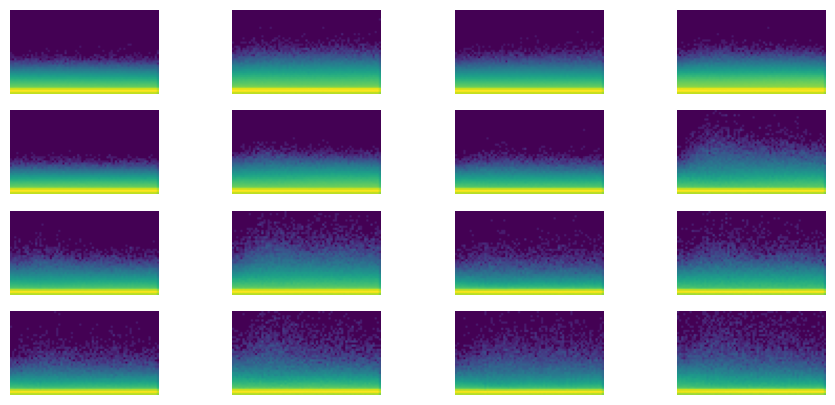

In [ ]:
astats.color_dim()

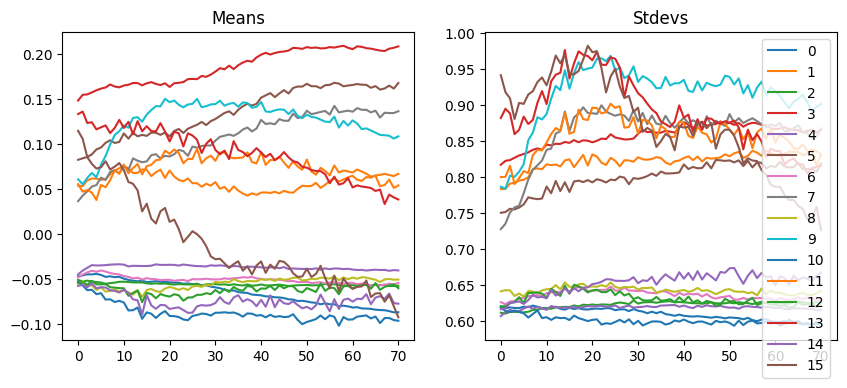

In [ ]:
astats.plot_stats()

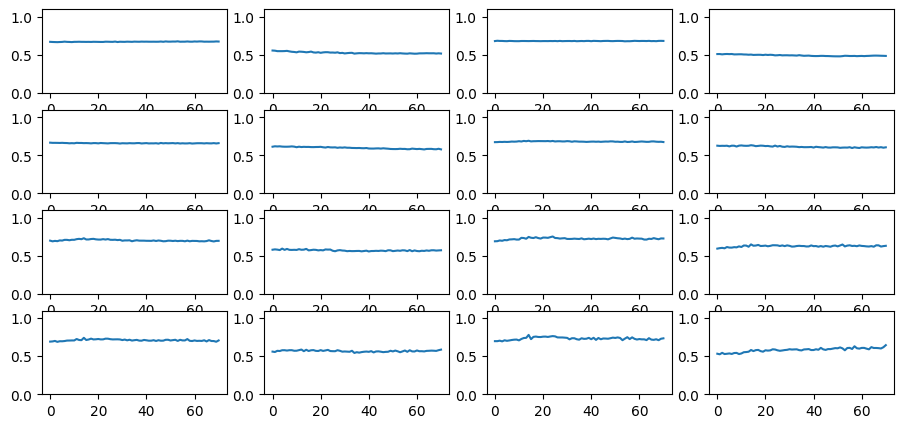

In [ ]:
astats.dead_chart()